# 1 - Accuracy error

Iteramos por los datasets de los directorios de **discrete** y **mixed**, agrupando sus accuracy errors

In [3]:
import pandas as pd
import json
import statistics as stats
from os import listdir
import numpy as np

methods = ["MEAN", "MICE", "GLFM", "HIVAE", "VBSEM"]
max_percentage = 5
n_runs = 5
directories = ["../../missing_results/discrete/"]
accuracy_error_dfs = []
data_names = [
        "hiv_test", 
        "house_building", 
        "hayes_roth",
        "balance_scale", 
        "hannover",
        "somerville",
        "car_evaluation",
        "nursery", 
        "breast_cancer", 
        "web_phishing",
        "solar_flare",
        "zoo",
        "vote", 
        "spect_heart",
        "alarm"
]


# Iterate through the missing percentage values, and for each dataset, recover the methods' results
for i in range(1, max_percentage):
    miss_percentage_string = "0" + str(i)

    df_error_results = pd.DataFrame()

    for data_name in data_names:
        error_results = {"dataset": data_name}
        for method_name in methods:
            json_name = data_name + "_" + miss_percentage_string + "_results_" + method_name + ".json"
            full_path = directory + data_name + "/" + json_name
            with open(full_path) as json_file:
                json_data = json.load(json_file)
                runs_data = json_data["runs"]
                errors = []
                learning_times = []
                for i in range(1, n_runs + 1):
                    errors.append(1.0 - runs_data["run_" + str(i)]["accuracy"]) 

                avg_error = stats.mean(errors)
                stdev_error = stats.stdev(errors)

                error_results[method_name] = avg_error

        df_error_results = df_error_results.append(error_results, ignore_index=True)

    accuracy_error_dfs.append(df_error_results)

In [4]:
accuracy_error_dfs[0]

,GLFM,HIVAE,MEAN,MICE,VBSEM,dataset
0,0.122807,0.072037,0.418713,0.090058,0.088889,hiv_test
1,0.503797,0.310659,0.441772,0.285232,0.284810,house_building
2,0.622500,0.617484,0.672500,0.565000,0.475000,hayes_roth
3,0.667308,0.498553,0.808974,0.654487,0.589103,balance_scale
4,0.199274,0.189996,0.207540,0.175202,0.175091,hannover
5,0.632000,0.530266,0.566000,0.580000,0.544000,somerville
6,0.591894,0.612227,0.680397,0.604963,0.579322,car_evaluation
7,0.625257,0.567458,0.691564,0.667061,0.557990,nursery
8,0.449819,0.379871,0.450542,0.380505,0.373285,breast_cancer
9,0.413895,0.347323,0.474353,0.419364,0.287509,web_phishing


## 1.1 - Average rank table

In [64]:
methods_without_MEAN = ["MICE", "GLFM", "HIVAE", "VBSEM"]
accuracy_error_mean_rank = pd.DataFrame(columns=methods_without_MEAN)
error_rank_dfs = []

for i in range(0,5):
    error_rank_df = accuracy_error_dfs[i][methods_without_MEAN].rank(method="max", axis = 1, ascending = 1)
    error_rank_df["dataset"] = accuracy_error_dfs[i]["dataset"]
    error_rank_dfs.append(error_rank_df)
    accuracy_error_mean_rank = accuracy_error_mean_rank.append(error_rank_df[methods_without_MEAN].mean(axis = 0), ignore_index=True)

accuracy_error_mean_rank["miss_percentage"] = [str(i)+"0%" for i in range(1,6)]
accuracy_error_mean_rank

,MICE,GLFM,HIVAE,VBSEM,miss_percentage
0,2.638889,3.222222,2.083333,2.138889,10%
1,2.694444,3.361111,1.916667,2.055556,20%
2,3.138889,3.166667,1.805556,1.888889,30%
3,3.166667,3.083333,1.888889,1.861111,40%
4,3.111111,3.222222,1.638889,2.027778,50%


In [ ]:
# Show the rank/error of each method for each dataset for a specific missing percentage
#error_rank_dfs[4]
#accuracy_error_dfs[0]

## 1.2 - Error plot

Para generar un bar plot tenemos que combinar los DFs de resultados en uno solo que tenga 4 columnas:
* dataset
* method
* percentage
* error_value

In [74]:
df_plot = pd.DataFrame(columns=["dataset", "method", "percentage", "accuracy_error"])

for percentage in range(0, 5):
    df = accuracy_error_dfs[percentage]
    percentage_string = str((percentage+1)*10) + "%"
    for method in methods:
        for i in range(len(df)):
            row = df.loc[i]
            instance = {"dataset": row["dataset"]}
            instance["percentage"] = percentage_string
            instance["method"] = method
            instance["accuracy_error"] = row[method]
            df_plot = df_plot.append(instance, ignore_index=True)            

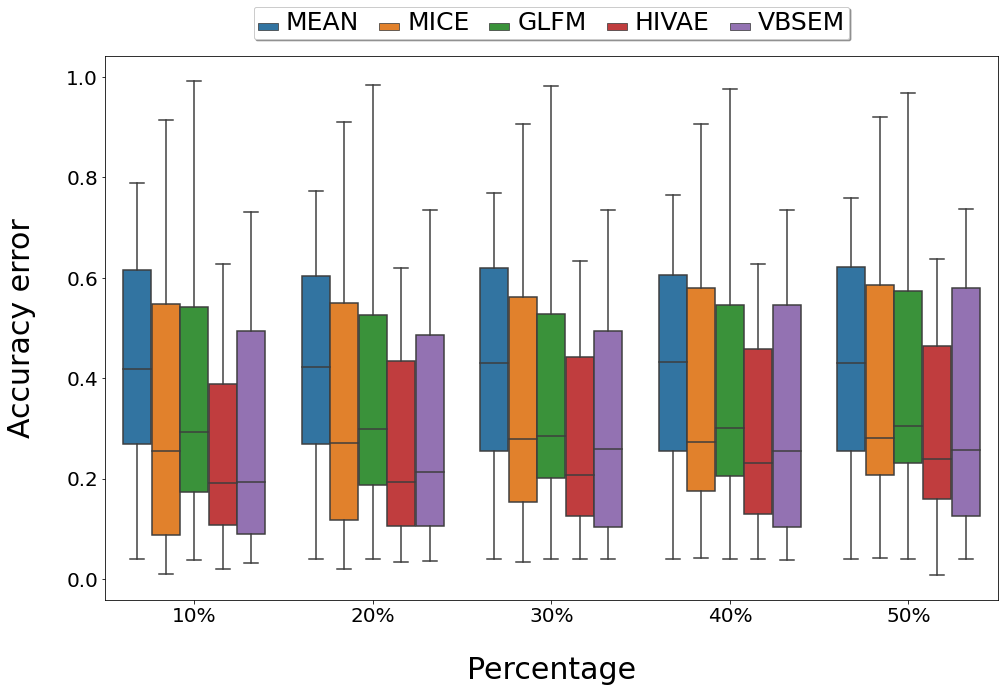

In [100]:
from matplotlib import pyplot as plt
import seaborn as sns

fig, ax = plt.subplots(figsize=(16,10))
g = sns.boxplot(data=df_plot,x="percentage", y="accuracy_error", hue="method", ax = ax)
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.10),
          ncol=5, fancybox=True, shadow=True)
plt.setp(ax.get_legend().get_texts(), fontsize='25') # for legend text
plt.setp(ax.get_legend().get_title(), fontsize='0') # for legend title
ax.tick_params(axis="x", labelsize=20) # x ticks font size
ax.tick_params(axis="y", labelsize=20) # y ticks font size
plt.xlabel('Percentage', fontsize=30, labelpad=30)
plt.ylabel('Accuracy error', fontsize=30, labelpad=30)

plt.savefig('plots/accuracy_error_plot.pdf')  

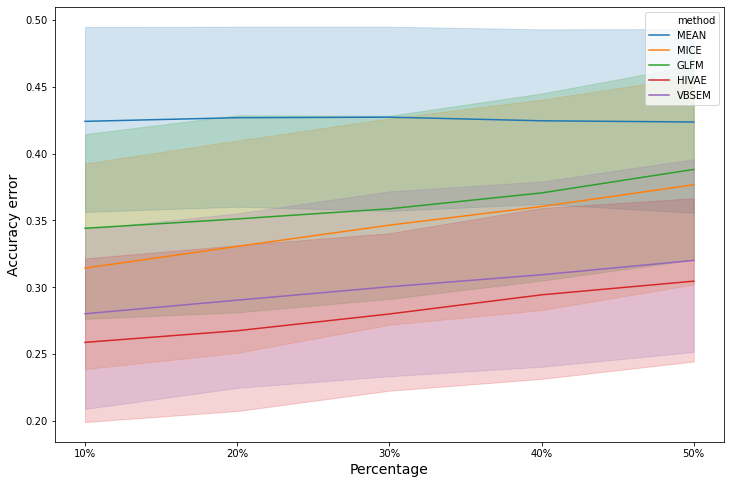

In [41]:
from matplotlib import pyplot as plt
import seaborn as sns

fig, ax = plt.subplots(figsize=(12,8))
g = sns.lineplot(data=df_plot,x="percentage", y="accuracy_error", hue="method", ax = ax)
plt.xlabel('Percentage', fontsize=14)
ylabel = plt.ylabel('Accuracy error', fontsize=14)

## 1.3 - Nemenyi tests

Missing percentage: 10%


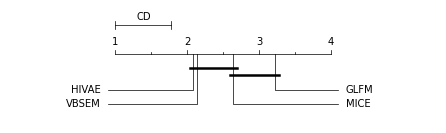

Missing percentage: 20%


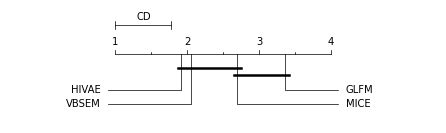

Missing percentage: 30%


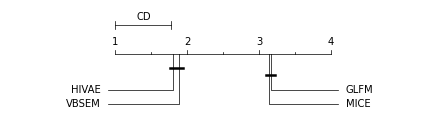

Missing percentage: 40%


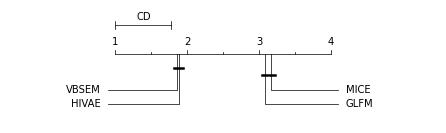

Missing percentage: 50%


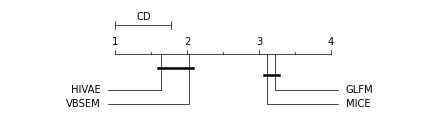

In [72]:
import Orange
import matplotlib.pyplot as plt

n_datasets = accuracy_error_dfs[0].shape[0]

for i in range(0, accuracy_error_mean_rank.shape[0]):
    avranks = accuracy_error_mean_rank[methods_without_MEAN].iloc[i].values
    cd = Orange.evaluation.compute_CD(avranks, n_datasets) #tested on 30 datasets
    Orange.evaluation.graph_ranks(avranks, methods_without_MEAN, cd=cd,width=6, textspace=1.5)
    print("Missing percentage: " + str(accuracy_error_mean_rank["miss_percentage"].iloc[i]))
    plt.savefig('plots/accuracy_error_' + str(accuracy_error_mean_rank["miss_percentage"].iloc[i]).replace("%", "") + '.svg')  
    plt.show()

# 2 - NRMSE

Iteramos por los datasets de los directorios de **continuous** y **mixed**, agrupando sus nrmses

In [59]:
import pandas as pd
import json
import statistics as stats
from os import listdir
import numpy as np

methods = ["MEAN", "MICE", "GLFM", "HIVAE", "VBSEM"]
max_percentage = 6
n_runs = 5
directories = ["selected_results/continuous/", "selected_results/mixed/"]
nrmse_dfs = []


# Iterate through the missing percentage values, and for each dataset, recover the methods' results
for i in range(1, max_percentage):
    miss_percentage_string = "0" + str(i)
    df_error_results = pd.DataFrame()

    for directory in directories:
        data_names = [file_name for file_name in listdir(directory)]

        for data_name in data_names:
            error_results = {"dataset": data_name}
            
            for method_name in methods:
                json_name = data_name + "_" + miss_percentage_string + "_results_" + method_name + ".json"
                full_path = directory + data_name + "/" + json_name
                
                with open(full_path) as json_file:
                    json_data = json.load(json_file)
                    runs_data = json_data["runs"]
                    errors = []
                    learning_times = []
                    for i in range(1, n_runs + 1):
                        errors.append(runs_data["run_" + str(i)]["nrmse"]) 

                    avg_error = stats.mean(errors)
                    stdev_error = stats.stdev(errors)

                    error_results[method_name] = avg_error

            df_error_results = df_error_results.append(error_results, ignore_index=True)

    nrmse_dfs.append(df_error_results)

## 2.1 - Average rank table

In [60]:
methods_without_MEAN = ["MICE", "GLFM", "HIVAE", "VBSEM"]
nrmse_mean_rank = pd.DataFrame(columns=methods_without_MEAN)
error_rank_dfs = []

for i in range(0,5):
    error_rank_df = nrmse_dfs[i][methods_without_MEAN].rank(method="max", axis = 1, ascending = 1)
    error_rank_df["dataset"] = nrmse_dfs[i]["dataset"]
    error_rank_dfs.append(error_rank_df)
    nrmse_mean_rank = nrmse_mean_rank.append(error_rank_df[methods_without_MEAN].mean(axis = 0), ignore_index=True)

nrmse_mean_rank["miss_percentage"] = [str(i)+"0%" for i in range(1,6)]
nrmse_mean_rank

,MICE,GLFM,HIVAE,VBSEM,miss_percentage
0,1.357143,3.642857,2.535714,2.464286,10%
1,1.500000,3.500000,2.678571,2.321429,20%
2,1.607143,3.464286,2.678571,2.250000,30%
3,1.964286,3.464286,2.357143,2.214286,40%
4,2.000000,3.535714,2.428571,2.035714,50%


In [ ]:
# Show the rank/error of each method for each dataset for a specific missing percentage
#error_rank_dfs[4]
#nrmse_dfs[0]

## 2.2 - Error plots

In [101]:
df_plot = pd.DataFrame(columns=["dataset", "method", "percentage", "NRMSE"])

for percentage in range(0, 5):
    df = nrmse_dfs[percentage]
    percentage_string = str((percentage+1)*10) + "%"
    for method in methods:
        for i in range(len(df)):
            row = df.loc[i]
            instance = {"dataset": row["dataset"]}
            instance["percentage"] = percentage_string
            instance["method"] = method
            instance["NRMSE"] = row[method]
            df_plot = df_plot.append(instance, ignore_index=True)

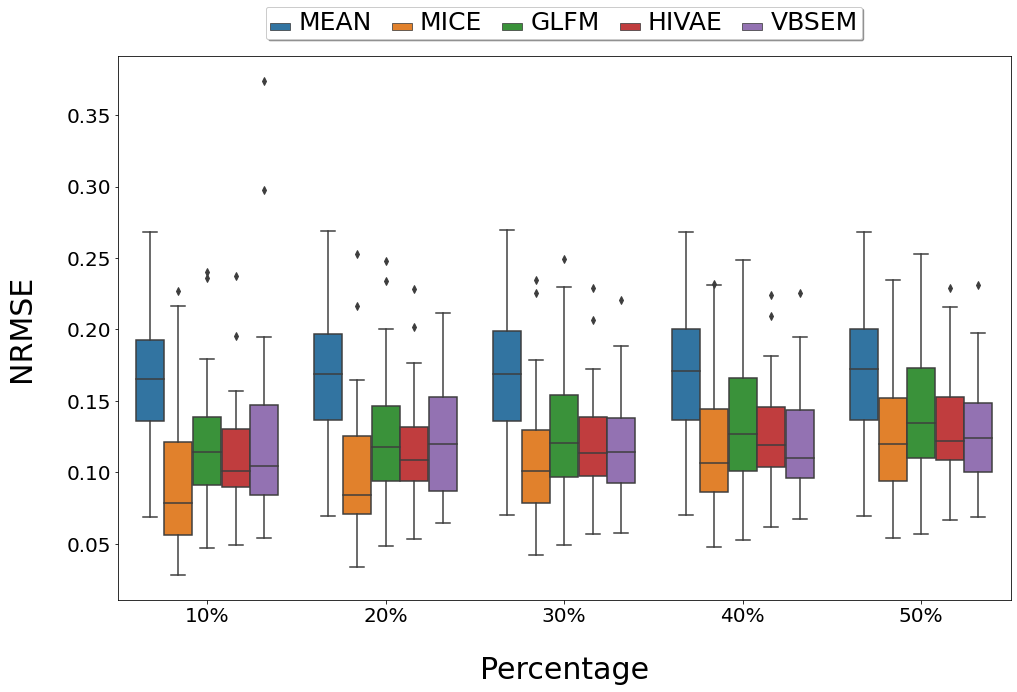

In [102]:
from matplotlib import pyplot as plt
import seaborn as sns

fig, ax = plt.subplots(figsize=(16,10))
g = sns.boxplot(data=df_plot,x="percentage", y="NRMSE", hue="method", ax = ax)
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.10),
          ncol=5, fancybox=True, shadow=True)
plt.setp(ax.get_legend().get_texts(), fontsize='25') # for legend text
plt.setp(ax.get_legend().get_title(), fontsize='0') # for legend title
ax.tick_params(axis="x", labelsize=20) # x ticks font size
ax.tick_params(axis="y", labelsize=20) # y ticks font size
plt.xlabel('Percentage', fontsize=30, labelpad=30)
plt.ylabel('NRMSE', fontsize=30, labelpad=30)

plt.savefig('plots/nrmse_plot.pdf')  

## 2.3 - Nemenyi tests

Missing percentage: 10%


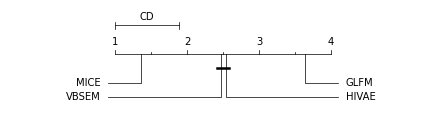

Missing percentage: 20%


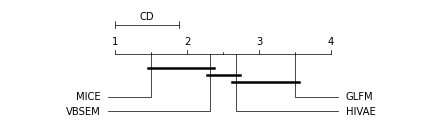

Missing percentage: 30%


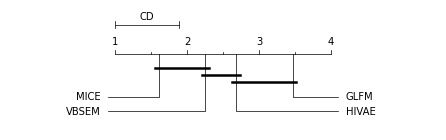

Missing percentage: 40%


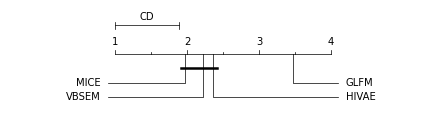

Missing percentage: 50%


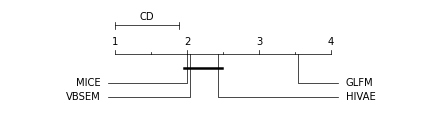

In [29]:
import Orange
import matplotlib.pyplot as plt

n_datasets = nrmse_dfs[0].shape[0]

for i in range(0, nrmse_mean_rank.shape[0]):
    avranks = nrmse_mean_rank[methods_without_MEAN].iloc[i].values
    cd = Orange.evaluation.compute_CD(avranks, n_datasets) #tested on 30 datasets
    Orange.evaluation.graph_ranks(avranks, methods_without_MEAN, cd=cd, width=6, textspace=1.5)   
    print("Missing percentage: " + str(nrmse_mean_rank["miss_percentage"].iloc[i]))
    plt.savefig('plots/nrmse_' + str(nrmse_mean_rank["miss_percentage"].iloc[i]).replace("%", "") + '.pdf')  
    plt.show()

# 3 - Average error

Iteramos por los directorios de **discrete**, **continuous** y **mixed**, agrupando sus errores como average_error

In [55]:
import pandas as pd
import json
import statistics as stats
from os import listdir
import numpy as np

methods = ["MEAN", "MICE", "GLFM", "HIVAE", "VBSEM"]
max_percentage = 6
n_runs = 5
directories = ["selected_results/discrete/", "selected_results/continuous/", "selected_results/mixed/"]
average_error_dfs = []

# Iterate through the missing percentage values, and for each dataset, recover the methods' results
for i in range(1, max_percentage):
    miss_percentage_string = "0" + str(i)

    df_error_results = pd.DataFrame()

    for directory in directories:       
        data_names = [file_name for file_name in listdir(directory)]

        for data_name in data_names:
            error_results = {"dataset": data_name}
            
            for method_name in methods:
                json_name = data_name + "_" + miss_percentage_string + "_results_" + method_name + ".json"
                full_path = directory + data_name + "/" + json_name
                with open(full_path) as json_file:
                    json_data = json.load(json_file)
                    runs_data = json_data["runs"]
                    errors = []
                    learning_times = []
                    for i in range(1, n_runs + 1):
                        if directory == "selected_results/discrete/":
                            errors.append(1.0 - runs_data["run_" + str(i)]["accuracy"])
                        elif directory == "selected_results/continuous/":
                            errors.append(runs_data["run_" + str(i)]["nrmse"])
                        else:
                            errors.append(runs_data["run_" + str(i)]["average_error"])

                    avg_error = stats.mean(errors)
                    stdev_error = stats.stdev(errors)

                    error_results[method_name] = avg_error

            df_error_results = df_error_results.append(error_results, ignore_index=True)

    average_error_dfs.append(df_error_results)

## 3.1 - Average rank table

In [56]:
methods_without_MEAN = ["MICE", "GLFM", "HIVAE", "VBSEM"]
average_error_mean_rank = pd.DataFrame(columns=methods_without_MEAN)
error_rank_dfs = []

for i in range(0,5):
    error_rank_df = average_error_dfs[i][methods_without_MEAN].rank(method="max", axis = 1, ascending = 1)
    error_rank_df["dataset"] = average_error_dfs[i]["dataset"]
    error_rank_dfs.append(error_rank_df)
    average_error_mean_rank = average_error_mean_rank.append(error_rank_df[methods_without_MEAN].mean(axis = 0), ignore_index=True)

average_error_mean_rank["miss_percentage"] = [str(i)+"0%" for i in range(1,6)]
average_error_mean_rank

,MICE,GLFM,HIVAE,VBSEM,miss_percentage
0,1.911111,3.555556,2.244444,2.288889,10%
1,2.066667,3.444444,2.288889,2.200000,20%
2,2.422222,3.311111,2.200000,2.066667,30%
3,2.622222,3.333333,2.111111,1.933333,40%
4,2.511111,3.466667,1.933333,2.088889,50%


In [13]:
# Show the rank/error of each method for each dataset for a specific missing percentage
#error_rank_dfs[4]
#average_error_dfs[0]

## 3.2 - Error plots

In [104]:
df_plot = pd.DataFrame(columns=["dataset", "method", "percentage", "AvgErr"])

for percentage in range(0, 5):
    df = average_error_dfs[percentage]
    percentage_string = str((percentage+1)*10) + "%"
    for method in methods:
        for i in range(len(df)):
            row = df.loc[i]
            instance = {"dataset": row["dataset"]}
            instance["percentage"] = percentage_string
            instance["method"] = method
            instance["AvgErr"] = row[method]
            df_plot = df_plot.append(instance, ignore_index=True)

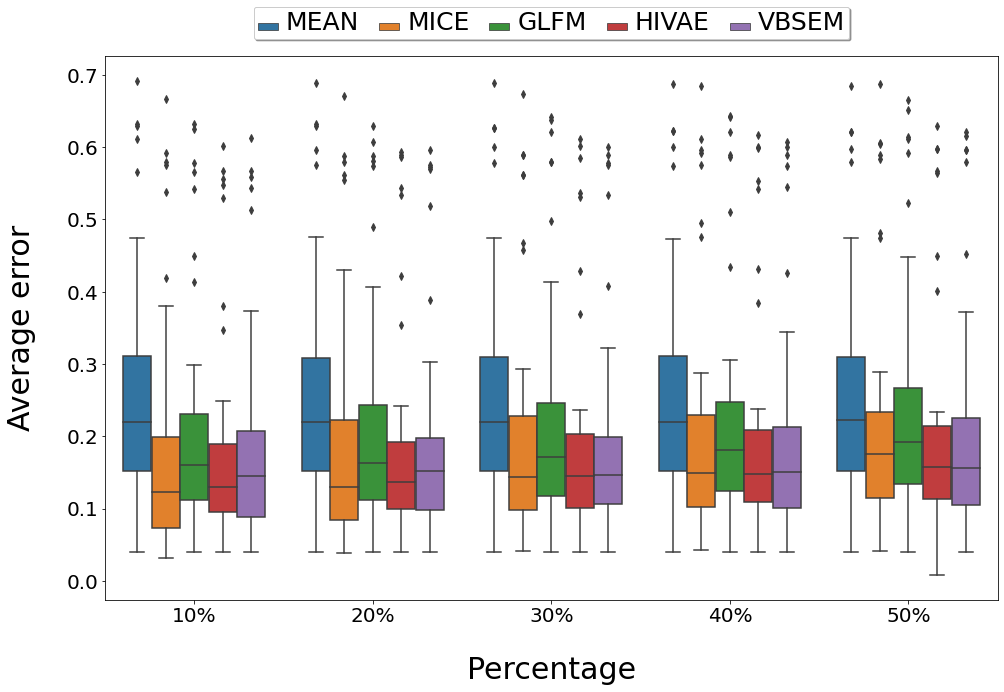

In [105]:
from matplotlib import pyplot as plt
import seaborn as sns

fig, ax = plt.subplots(figsize=(16,10))
g = sns.boxplot(data=df_plot,x="percentage", y="AvgErr", hue="method", ax = ax)
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.10),
          ncol=5, fancybox=True, shadow=True)
plt.setp(ax.get_legend().get_texts(), fontsize='25') # for legend text
plt.setp(ax.get_legend().get_title(), fontsize='0') # for legend title
ax.tick_params(axis="x", labelsize=20) # x ticks font size
ax.tick_params(axis="y", labelsize=20) # y ticks font size
plt.xlabel('Percentage', fontsize=30, labelpad=30)
plt.ylabel('Average error', fontsize=30, labelpad=30)

plt.savefig('plots/average_error_plot.pdf')  

## 3.3 - Nemenyi tests

Missing percentage: 10%


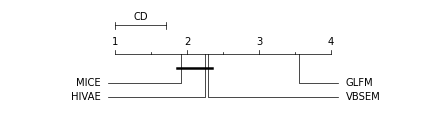

Missing percentage: 20%


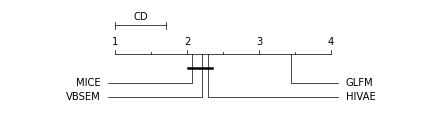

Missing percentage: 30%


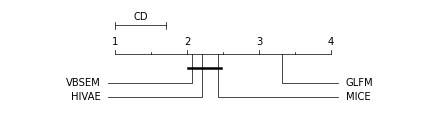

Missing percentage: 40%


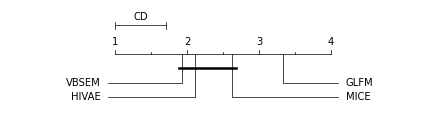

Missing percentage: 50%


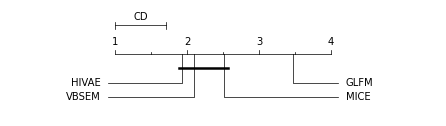

In [32]:
import Orange
import matplotlib.pyplot as plt

n_datasets = average_error_dfs[0].shape[0]

for i in range(0, average_error_mean_rank.shape[0]):
    avranks = average_error_mean_rank[methods_without_MEAN].iloc[i].values
    cd = Orange.evaluation.compute_CD(avranks, n_datasets) #tested on 30 datasets
    Orange.evaluation.graph_ranks(avranks, methods_without_MEAN, cd=cd, width=6, textspace=1.5)
    print("Missing percentage: " + str(average_error_mean_rank["miss_percentage"].iloc[i]))
    plt.savefig('plots/average_error_' + str(average_error_mean_rank["miss_percentage"].iloc[i]).replace("%", "") + '.pdf')  
    plt.show()

# 4 - Learning time

Iteramos por los directorios de **discrete**, **continuous** y **mixed**, agrupando sus tiempos de ejecucion

In [17]:
import pandas as pd
import json
import statistics as stats
from os import listdir
import numpy as np

methods = ["MEAN", "GLFM", "HIVAE", "MICE", "VBSEM"]
max_percentage = 6
n_runs = 5
directories = ["selected_results/discrete/", "selected_results/continuous/", "selected_results/mixed/"]
time_dfs = []


# Iterate through the missing percentage values, and for each dataset, recover the methods' results
for i in range(1, max_percentage):
    miss_percentage_string = "0" + str(i)

    df_time_results = pd.DataFrame()

    for directory in directories:
        data_names = [file_name for file_name in listdir(directory)]

        for data_name in data_names:
            time_results = {"dataset": data_name}
            for method_name in methods:
                json_name = data_name + "_" + miss_percentage_string + "_results_" + method_name + ".json"
                full_path = directory + data_name + "/" + json_name
                with open(full_path) as json_file:
                    json_data = json.load(json_file)
                    runs_data = json_data["runs"]
                    learning_times = []
                    for i in range(1, n_runs + 1):
                        learning_times.append(runs_data["run_" + str(i)]["learning_time"]) 

                    avg_learning_time = stats.mean(learning_times) / 1000
                    stdev_learning_time = stats.stdev(learning_times) / 1000

                    time_results[method_name] = avg_learning_time

            df_time_results = df_time_results.append(time_results, ignore_index=True)

    time_dfs.append(df_time_results)

## 4.1 -Average rank table

In [18]:
methods_without_MEAN = ["MICE", "GLFM", "HIVAE", "VBSEM"]
time_mean_rank = pd.DataFrame(columns=methods_without_MEAN)

for i in range(0,5):
    time_rank_df = time_dfs[i][methods_without_MEAN].rank(method="max", axis = 1, ascending = 1)
    time_mean_rank = time_mean_rank.append(time_rank_df.mean(axis = 0), ignore_index=True)

time_mean_rank["miss_percentage"] = [str(i)+"0%" for i in range(1,6)]
time_mean_rank

,MICE,GLFM,HIVAE,VBSEM,miss_percentage
0,1.0,3.288889,3.066667,2.644444,10%
1,1.0,3.222222,3.044444,2.733333,20%
2,1.0,3.155556,3.133333,2.711111,30%
3,1.0,3.155556,3.111111,2.733333,40%
4,1.0,3.133333,3.111111,2.755556,50%


## 4.2 - Nemenyi tests

Missing percentage: 10%


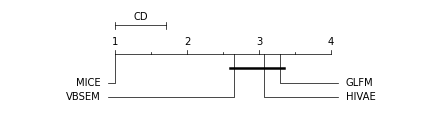

Missing percentage: 20%


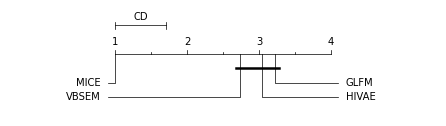

Missing percentage: 30%


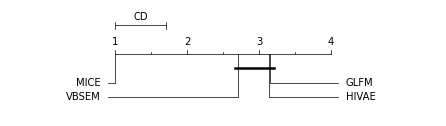

Missing percentage: 40%


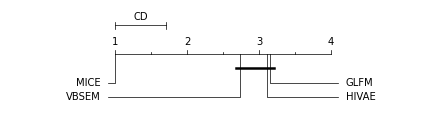

Missing percentage: 50%


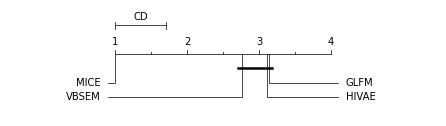

In [31]:
import Orange
import matplotlib.pyplot as plt

n_datasets = time_dfs[0].shape[0]

for i in range(0, time_mean_rank.shape[0]):
    avranks = time_mean_rank[methods_without_MEAN].iloc[i].values
    cd = Orange.evaluation.compute_CD(avranks, n_datasets) #tested on 30 datasets
    Orange.evaluation.graph_ranks(avranks, methods_without_MEAN, cd=cd, width=6, textspace=1.5)
    print("Missing percentage: " + str(time_mean_rank["miss_percentage"].iloc[i]))
    plt.savefig('plots/learning_time_' + str(time_mean_rank["miss_percentage"].iloc[i]).replace("%", "") + '.pdf')  
    plt.show()